# Global Warning Sentiment - Word Model

In [264]:
import numpy as np
from functools import partial
import pandas as pd

import torchtext
import torch
from torch import nn
from torch.nn import functional as F
import spacy
import fastai.nlp
from fastai.learner import fit
from fastai.core import V
from fastai.metrics import accuracy
from fastai.lm_rnn import seq2seq_reg, repackage_var

from pathlib import Path

In [186]:
df = pd.read_csv('./data/raw/global_warming_tweets.csv', encoding='latin1')

Drop all Tweets that aren't about global warming:

In [187]:
df = df.dropna()

In [188]:
df.existence = df.existence.replace({'Yes': 'Y', 'No': 'N'})

In [189]:
df.existence.value_counts(dropna=False)

Y    3111
N    1114
Name: existence, dtype: int64

In [190]:
df = df.sample(frac=1, random_state=42)

In [191]:
train_df = df[:-1000]
val_df = df[-1000:]

In [192]:
train_df.shape

(3225, 3)

In [193]:
val_df.shape

(1000, 3)

In [194]:
train_df.existence.value_counts()

Y    2384
N     841
Name: existence, dtype: int64

In [195]:
val_df.existence.value_counts()

Y    727
N    273
Name: existence, dtype: int64

## Simple classifier

### Torchtext basics

I'll start with a very simple classifier that uses just one RNN layer. I won't even use a learner object for this and only the `fit` Fast.ai function.

The `data.Field` PyTorch classes describe how to process a set of text. In this example, we intend to lowercase each string:

`HELLO` -> `hello`

and tokenise it with Spacy.

In [196]:
nlp = spacy.load('en')

In [197]:
train_df.iloc[0].tweet

"Putting a Price on Climate Change: The People's World Conference on Climate Change in Cochabamba, Bolivia kicks... http://bit.ly/8XnI5N #p2"

In [198]:
tokens = nlp(train_df.iloc[0].tweet)

In [199]:
[t for t in tokens]

[Putting,
 a,
 Price,
 on,
 Climate,
 Change,
 :,
 The,
 People,
 's,
 World,
 Conference,
 on,
 Climate,
 Change,
 in,
 Cochabamba,
 ,,
 Bolivia,
 kicks,
 ...,
 http://bit.ly/8XnI5N,
 #,
 p2]

In [200]:
TEXT_FIELD = torchtext.data.Field(lower=True, tokenize="spacy")
LABEL_FIELD = torchtext.data.Field(sequential=False)

We'll also need a Dataset. Which in Torch text is an object that stores a list of `examples` which includes the text, it's label and the `Field` used to process it.

In [201]:
class DataFrameDataset(torchtext.data.Dataset):

    def __init__(self, df, text_field, label_field, is_test=False, **kwargs):
        fields = [('text', text_field), ('label', label_field)]
        examples = []
        for i, row in df.iterrows():
            label = row.existence if not is_test else None
            text = row.tweet
            examples.append(torchtext.data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    @classmethod
    def splits(cls, text_field, label_field, train_df, val_df=None, test_df=None, **kwargs):
        train_data, val_data, test_data = (None, None, None)

        if train_df is not None:
            train_data = cls(train_df.copy(), text_field, label_field, **kwargs)
        if val_df is not None:
            val_data = cls(val_df.copy(), text_field, label_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), text_field, label_field, True, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)

`splits` refers to the train, val and test split and is a big part of the Torchtext lingo. Here's how you would construct split:

In [202]:
train_ds, val_ds, test_ds = DataFrameDataset.splits(
  text_field=TEXT_FIELD, label_field=LABEL_FIELD, train_df=train_df, val_df=val_df, test_df=val_df)

We can now prepare our `TEXT_FIELD` by building the vocab on it, which simply maps tokens to ints:

In [203]:
TEXT_FIELD.build_vocab(train_ds)

In [204]:
TEXT_FIELD.vocab.stoi['globalwarming']

344

In [205]:
TEXT_FIELD.vocab.itos[378]

'long'

In [206]:
LABEL_FIELD.build_vocab(train_df)

A dataset is very much like a list: it can be iterated through and we can also fetch individual items by id:

In [207]:
train_ds[100].text

['boy', '.', 'global', 'warming', 'is', 'one', 'slick', 'buster', '.']

In [208]:
next(iter(train_ds)).text

['putting',
 'a',
 'price',
 'on',
 'climate',
 'change',
 ':',
 'the',
 'people',
 "'s",
 'world',
 'conference',
 'on',
 'climate',
 'change',
 'in',
 'cochabamba',
 ',',
 'bolivia',
 'kicks',
 '...',
 'http://bit.ly/8xni5n',
 '#',
 'p2']

What we want is a tool to batch our examples up for us. Since an RNN is a sequence model, which can support variable length sequences (lists of data), what we want is a batching strategy that will let us train on multiple sentences at a time but still let us use a for loop over them. Torchtext solves the problem like this:

First element   |  Second element   |
['rt']             ['the']
['global']         ['warming']
['Hello']          ['world']

So the first element is 64x1, which is the first word in 64 different sequences and so on.

Torchtext provides a "bucket iterator" which handles batching. In Torchtext, they call these iterators what Torchvision called data loaders (no idea why that is).

Let's create an iterator for each split:

In [209]:
train_iter, val_iter, test_iter = torchtext.data.BucketIterator.splits(
    (train_ds, val_ds, test_ds), batch_sizes=(16, 256, 256), sort_key=lambda x: len(x.text))

In [210]:
train_batch = next(iter(train_iter))

In [211]:
train_batch.text.shape

torch.Size([32, 16])

What we have is a sentence length of 34, with a batch size of 16.

In [212]:
train_batch = next(iter(train_iter))

In [213]:
train_batch.text.shape

torch.Size([29, 16])

Notice how the sequence length changes each time? An RNN can handle that just fine.

Fast.AI provides a conveinience wrapper around all this called `fastai.nlp.TextData`. Let's use that and make sure it appears to work the same:

In [214]:
PATH = Path('./data/global-sentiment')
PATH.mkdir(exist_ok=True)
bs = 16

In [215]:
text_data = fastai.nlp.TextData.from_splits(PATH, (train_ds, val_ds, test_ds), bs=bs, text_name='text', label_name='label')

In [216]:
train_batch, y = next(iter(text_data.trn_dl))

In [217]:
train_batch.shape

torch.Size([32, 16])

In [218]:
train_batch, y = next(iter(text_data.trn_dl))

In [219]:
train_batch.shape

torch.Size([29, 16])

It's the same. Okay, so now we understand `TextData`, let's build a simple RNN model. I will use a for loop initially, instead of using the `nn.RNN` class.

In [220]:
class RNNClassifier(torch.nn.Module):
    def __init__(self, embedding_dim, hidden_size, vocab_size):
        super().__init__()
        
        self.hidden_size = hidden_size
        
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.input_layer = torch.nn.Linear(embedding_dim + hidden_size, hidden_size)
        self.hidden_layer = torch.nn.Linear(hidden_size, hidden_size)
        self.output_layer = torch.nn.Linear(hidden_size, vocab_size)
        
    def forward(self, words):
        batch_size = words[0].size(0)
        
        hidden = V(torch.zeros(batch_size, self.hidden_size))
        
        for word in words:
            e = self.embedding(word)
            concat = torch.cat([hidden, e], dim=1)
            inp = self.input_layer(concat)
            inp = torch.nn.functional.relu(inp)

            hidden = torch.nn.functional.tanh(self.hidden_layer(inp))
            
        return torch.nn.functional.log_softmax(self.output_layer(hidden), dim=-1)

In [221]:
emb_size = 50
hidden_size = 256
vocab_size = len(TEXT_FIELD.vocab.stoi)

model = RNNClassifier(emb_size, hidden_size, vocab_size)
opt = torch.optim.Adam(model.parameters(), 1e-3)

In [222]:
from fastai.nlp import RNN_Learner

In [223]:
learner = RNN_Learner.from_model_data(model, text_data)

In [224]:
learner.lr_find()

 84%|████████▎ | 169/202 [00:10<00:02, 16.46it/s, loss=11.5]

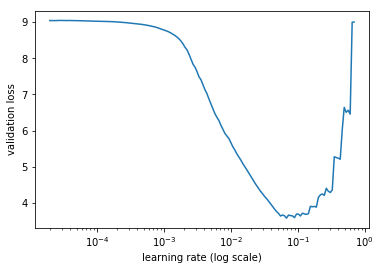

In [225]:
learner.sched.plot()

In [226]:
learner.fit(0.02, 1, metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy                    
    0      1.147053   0.679698   0.506759  


[array([0.6797]), 0.5067594834543987]

In [227]:
learner.fit(0.02, 3, metrics=[accuracy], cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.732736   0.670736   0.626261  
    1      0.587422   0.683923   0.703138                    
    2      0.605925   0.628018   0.710654                    
    3      0.584323   0.618647   0.716959                    
    4      0.578456   0.616663   0.706215                    
    5      0.586006   0.688242   0.591757                    
    6      0.586797   0.656099   0.633727                    


[array([0.6561]), 0.633726795803067]

In [228]:
learner.fit(0.005, 3, metrics=[accuracy], cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.551233   0.6378     0.665708  
    1      0.54869    0.652776   0.633929                    
    2      0.545327   0.619783   0.666515                    
    3      0.566465   0.607397   0.696529                    
    4      0.564823   0.644541   0.638771                    
    5      0.5511     0.699693   0.628682                    
    6      0.570328   0.64961    0.641243                    


[array([0.64961]), 0.6412429378531074]

Results are not amazing. We know that loosing the hidden state in between forward passes is not ideal. Can we try the stateful RNN model>

In [294]:
class StatefulRNNClassifier(nn.Module):
    def __init__(self, vocab_size, n_fac, n_hidden, batch_size):
        self.vocab_size = vocab_size
        self.n_hidden = n_hidden
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.RNN(n_fac, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(batch_size)
        
    def forward(self, cs):
        batch_size = cs[0].size(0)
        if self.h.size(1) != batch_size:
            self.init_hidden(batch_size)

        outp, h = self.rnn(self.e(cs), self.h)
        self.h = repackage_var(h)
        return F.log_softmax(self.l_out(outp[-1]), dim=-1).view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.h = V(torch.zeros(1, bs, self.n_hidden))

In [295]:
emb_size = 50
hidden_size = 256
vocab_size = len(TEXT_FIELD.vocab.stoi)

model = StatefulRNNClassifier(vocab_size, emb_size, hidden_size, 16)
opt = torch.optim.Adam(model.parameters(), 1e-3)

In [296]:
learner = RNN_Learner.from_model_data(model, text_data)

In [297]:
learner.model.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.model.clip = 25.

In [298]:
learner.unfreeze()

In [299]:
learner.lr_find()

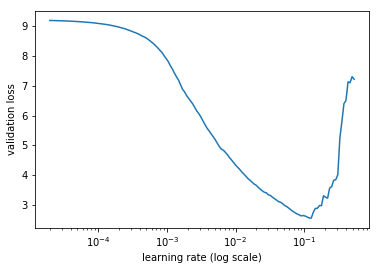

In [300]:
learner.sched.plot()

In [301]:
learner.fit(0.02, 1, metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy                    
    0      0.819542   0.709616   0.709443  


[array([0.70962]), 0.7094430992736077]

In [302]:
learner.fit(0.02, 3, metrics=[accuracy], cycle_mult=3)

epoch      trn_loss   val_loss   accuracy                    
    0      0.708777   0.683185   0.707627  
    1      0.675775   0.610942   0.705962                    
    2      0.704993   0.802834   0.428622                    
    3      0.618514   0.642599   0.650172                    
    4      0.672827   0.611914   0.700212                    
    5      0.6107     0.60831    0.704651                    
    6      0.651113   0.614211   0.714084                    
    7      0.62858    0.643714   0.699354                    
    8      0.610845   0.802748   0.550797                    
    9      0.589073   0.651614   0.674738                    
    10     0.609455   0.657861   0.68528                     
    11     0.572956   0.689398   0.655266                    
    12     0.605903   0.77662    0.60679                     


[array([0.77662]), 0.6067897497982244]

In [304]:
learner.fit(0.001, 1, metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy                    
    0      0.540366   0.68438    0.679933  


[array([0.68438]), 0.6799334140435835]

In [305]:
learner.fit(0.001, 3, metrics=[accuracy], cycle_mult=3)

epoch      trn_loss   val_loss   accuracy                    
    0      0.540557   0.684911   0.673123  
    1      0.526347   0.673157   0.673577                    
    2      0.511267   0.670735   0.673779                    
    3      0.545665   0.678953   0.668987                    
    4      0.524892   0.680443   0.668533                    
    5      0.544276   0.684007   0.668483                    
    6      0.523531   0.674075   0.674385                    
    7      0.513912   0.677873   0.672266                    
    8      0.520259   0.679552   0.667524                    
    9      0.531105   0.670982   0.675242                    
    10     0.528492   0.675993   0.67504                     
    11     0.520752   0.682534   0.673325                    
    12     0.533367   0.678197   0.683263                    


[array([0.6782]), 0.6832627118644068]

## Swap out the RNN for an LSTM

An LSTM does a better job at keeping track at longer term dependancies.

In [333]:
class StatefulLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, n_fac, n_hidden, batch_size, nl):
        self.nl = nl
        self.vocab_size = vocab_size
        self.n_hidden = n_hidden
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.LSTM(n_fac, n_hidden, self.nl)
        self.l_out = nn.Linear(n_hidden, vocab_size, 2)
        self.init_hidden(batch_size)
        
    def forward(self, cs):
        batch_size = cs[0].size(0)
        if self.h[0].size(1) != batch_size:
            self.init_hidden(batch_size)

        outp, h = self.rnn(self.e(cs), self.h)
        self.h = repackage_var(h)
        return F.log_softmax(self.l_out(outp[-1]), dim=-1).view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.h = (V(torch.zeros(self.nl, bs, self.n_hidden)),
                  V(torch.zeros(self.nl, bs, self.n_hidden)))

In [334]:
emb_size = 50
hidden_size = 256
vocab_size = len(TEXT_FIELD.vocab.stoi)

model = StatefulLSTMClassifier(vocab_size, emb_size, hidden_size, 16, 2)
opt = torch.optim.Adam(model.parameters(), 1e-3)

In [335]:
learner = RNN_Learner.from_model_data(model, text_data)

In [336]:
learner.unfreeze()

In [337]:
learner.lr_find()

epoch      trn_loss   val_loss                              
    0      10.172707  54.238545 


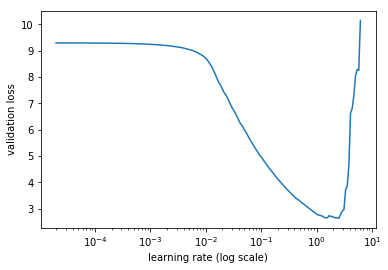

In [338]:
learner.sched.plot()

In [339]:
learner.fit(0.1, 3, metrics=[accuracy], cycle_mult=3)

epoch      trn_loss   val_loss   accuracy                    
    0      0.642714   0.664135   0.704802  
    1      0.590536   0.958193   0.293584                    
    2      0.587968   0.612797   0.703138                    
    3      0.579308   0.803199   0.464033                    
    4      0.557207   0.715474   0.60679                     
    5      0.535623   0.637085   0.653148                    
    6      0.503278   0.558036   0.720642                    
    7      0.464245   0.554885   0.728965                    
    8      0.45296    0.534932   0.744149                    
    9      0.45852    0.532461   0.717514                    
    10     0.407448   0.551546   0.754843                    
    11     0.437047   0.818363   0.615365                    
    12     0.393547   0.673225   0.735472                    


[array([0.67323]), 0.7354721549636803]

In [340]:
learner.fit(0.1, 3, metrics=[accuracy], cycle_mult=3)

epoch      trn_loss   val_loss   accuracy                    
    0      0.336083   0.588867   0.765234  
    1      0.299134   0.682336   0.766646                    
    2      0.274451   0.688969   0.772296                    
    3      0.237138   0.760314   0.768261                    
    4      0.2239     0.69131    0.786168                    
    5      0.165534   0.848869   0.774617                    
    6      0.140051   0.887794   0.748234                     
    7      0.123986   0.858684   0.769471                     
    8      0.121634   0.877789   0.777038                     
    9      0.111991   0.986204   0.774314                     
    10     0.089316   1.019616   0.772952                     
    11     0.066097   1.050458   0.782536                     
    12     0.059231   1.125723   0.752522                     


[array([1.12572]), 0.7525221953188055]

### Use the Fast.ai RNN classifier

The TextData has it's own model, let's try that.

In [343]:
opt_fn = partial(torch.optim.Adam, betas=(0.7, 0.99))

In [347]:
bs = 64
bptt = 70
em_sz = 200
nh = 500
nl = 3

In [350]:
learner = text_data.get_model(
    opt_fn, 1500, bptt, emb_sz=em_sz, n_hid=nh, n_layers=nl, 
    dropout=0.1, dropouti=0.4, wdrop=0.5, dropoute=0.05, dropouth=0.3)

In [351]:
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip = 0.3

In [353]:
learner.fit(3e-3, 4, wds=1e-6, cycle_len=1, cycle_mult=2, metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy                    
    0      0.443257   0.441434   0.799839  
    1      0.400259   0.442425   0.810079                    
    2      0.230633   0.489648   0.814064                    
    3      0.285576   0.551397   0.791969                    
    4      0.180654   0.557323   0.806346                    
    5      0.093521   0.695915   0.819713                     
    6      0.062698   0.712635   0.811188                     
    7      0.136172   0.685649   0.796459                    
    8      0.127845   0.760456   0.808464                    
    9      0.112893   0.684406   0.801049                     
    10     0.065658   0.868925   0.802008                     
    11     0.058279   0.936511   0.812096                     
    12     0.04041    0.980632   0.804126                     
    13     0.025297   0.946414   0.802008                     
    14     0.029456   0.958428   0.802411                     


[array([0.95843]), 0.802411218724778]

## Making test predictions

Though the dataset is quite small, it still might just be big enough for us to train a useful word model